<a href="https://colab.research.google.com/github/imrealhelper/Linear-Algebra/blob/main/Model_predictive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cvxpy as cp
import numpy as np
from scipy.linalg import expm

g =  9.8067  # 표준중력

Para = {
    # --- 미사일 공력계수 ---
    "Z_alpha" : -2.9399,   # [1/s]
    "Z_delta" : -0.6497,   # [1/s]
    "M_alpha" : -623.6149, # [1/s^2]
    "M_q"     : -5.0,      # [1/s]
    "M_delta" : -554.4808, # [1/s^2]
    "omega_a" : 100.0,     # 액추에이터 다이나믹스 (1/s)

    # --- 미사일 / 제약 ---
    "v_m"     : 380.0,     # 미사일 속도 (m/s)
    "a_m_max" : 12.0*g,    # 12 g
    "eps_max" : np.deg2rad(20.0),  # 20 deg => rad

    # --- 시커 해상도 (굳이 사용안해도 됨, 일단 예시) ---
    "S_fv"    : np.deg2rad(20.0),  # field of view
    "S_r"     : 256,

    # --- MPC 설정 ---
    "t_c"     : 3.0,       # 전체 유도종료시간 (논문 예시)
    "dt_c"    : 0.05,      # 샘플링 간격
    # N = t_c / dt_c -> 아래에서 계산
}

Target_para = {
      "v_t" : 10,
      "gamma_t":0.2
}

def make_continuous_matrix(para,Target_para):
  Continous_A = np.zeros([5,5])
  Continous_B = np.zeros([5,1])
  Continous_b = np.zeros([5,1])
  Continous_A[0] = np.array([-para["omega_a"],0,0,0,0])
  Continous_A[1] = np.array([para["Z_delta"],para["Z_alpha"],1,0,0])
  Continous_A[2] = np.array([para["M_delta"],para["M_alpha"],para["M_q"],0,0])
  Continous_A[3] = np.array([-para["Z_delta"],-para["Z_alpha"],0,0,0])
  Continous_A[4][3] = -para["v_m"]
  Continous_B[0,0] = para["omega_a"]
  Continous_b[-1,0] = Target_para["v_t"] * np.sin(Target_para["gamma_t"])

  return Continous_A, Continous_B, Continous_b


def continuous_to_discrite_matrix(Continous_A,Continous_B,Continous_b,para):
  A = expm(Continous_A*para["dt_c"])
  n = 10
  m_dt = para["dt_c"] / n
  B_A = np.zeros_like(A)
  #n개로 차분화
  for i in range(n):
    B_A +=  (expm(Continous_A*m_dt*i) + expm(Continous_A*m_dt*(i+1)))/2 * m_dt
  B = B_A@Continous_B
  b = B_A@Continous_b
  return A,B,b


Continous_A, Continous_B, Continous_b = make_continuous_matrix(Para,Target_para)
A,B,b = continuous_to_discrite_matrix(Continous_A,Continous_B,Continous_b,Para)

def look_angle(z_m,alpha_m,gamma_m,R):
  look_angle = z_m/R - alpha_m - gamma_m
  return look_angle


def range_to_go(R_0,para,Target_para,k):
  Range_k = R_0 - k * (para["v_m"] + Target_para["v_t"])*para["dt_c"]
  return Range_k


def look_angle_constraints(para,Range_k):
  R_k = Range_k
  C_k = np.zeros((4,5))
  C_k[0] = np.array([para["v_m"]*para["Z_delta"],para["v_m"]*para["Z_alpha"],0,0,0])
  C_k[1] = np.array([-para["v_m"]*para["Z_delta"],-para["v_m"]*para["Z_alpha"],0,0,0])
  C_k[2] = np.array([0,-1,0,-1,1/R_k])
  C_k[3] = np.array([0,1,0,1,-1/R_k])
  return C_k



def MPC(x_0, Q_k, Q_N, R_k_list, N, R_0, A, B, b, D, Para, Target_para):
    nx = A.shape[0]
    nu = B.shape[1]
    x = cp.Variable((nx, N+1))
    u = cp.Variable((nu, N))
    constraints = []
    cost = 0.0
    constraints.append(x[:, 0] == x_0.flatten())

    # 메인 루프 (k = 0..N-1)
    for k in range(N):
        # 1) 비용항
        #    Q_k, R_k_list 가 모두 "행렬" 형태라고 가정
        cost += cp.quad_form(x[:, k], Q_k) + cp.quad_form(u[:, k], R_k_list[k])
        constraints.append(x[:, k+1] == A @ x[:, k] + B @ u[:, k] + b.flatten())
        R_k_ = range_to_go(R_0, Para, Target_para, k)
        C_k = look_angle_constraints(Para, R_k_)
        constraints.append(C_k @ x[:, k] <= D.flatten())

    # 최종상태 비용
    cost += cp.quad_form(x[:, N], Q_N)

    # ---- 문제 정의 및 풀이
    prob = cp.Problem(cp.Minimize(cost), constraints)
    result = prob.solve()

    return x.value, u.value, result, prob.status



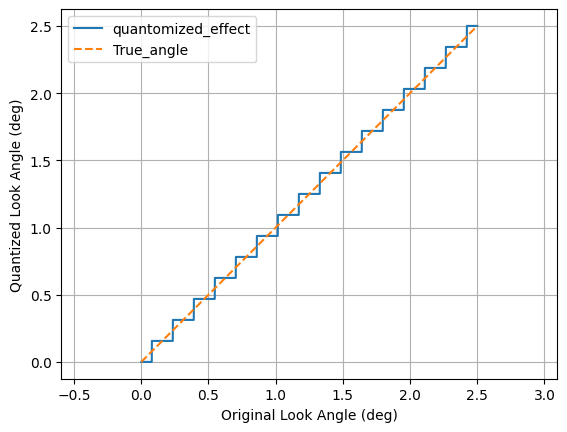

In [2]:
#look angle property_test


S_r = 128
S_fv = np.deg2rad(20)
e = np.array([i*np.deg2rad(2.5)/10000 for i in range(10001)])
e_q = S_fv / S_r * np.round(e/(S_fv/S_r))
import matplotlib.pyplot as plt
plt.plot(np.rad2deg(e),np.rad2deg(e_q),label = "quantomized_effect")
plt.plot(np.rad2deg(e),np.rad2deg(e),"--",label = "True_angle")
plt.xlabel("Original Look Angle (deg)")
plt.ylabel("Quantized Look Angle (deg)")
plt.axis("equal")  # 두 축의 크기를 동일하게 설정
plt.grid(True)  # 그리드 추가해서 보기 편하게
plt.legend()
plt.show()

In [3]:
def process_noise_target(x_e_k,t_e,Q_e):
  P_A = np.zeros((4,4))
  P_A[0] = np.array([1,t_e,0,0])
  P_A[0] = np.array([0,1,0,0])
  P_A[0] = np.array([0,0,1,t_e])
  P_A[0] = np.array([0,0,0,1])
  mean = np.zeros(4)
  w_e = np.random.multivariate_normal(mean, Q_e)
  x_e_noise = P_A@x_e_k + w_e
  return x_e_noise

def look_angle_noise(x_t,x_m,z_t,z_m, alpha_m,gamma_m,R_e):
  theta_m = alpha_m + gamma_m
  y_e_k = np.arctan(       (-(np.sin(theta_m) * (x_t-x_m)+np.cos(theta_m)*(z_t-z_m)))/(np.cos(theta_m)*(x_t-x_m) - np.sin(theta_m)*(z_t-z_m))) + np.random.randn(0,R_e)
  return y_e_k





def pitch_angle(alpha_m,gamma_m):
  theta_m = alpha_m + gamma_m
  return theta_m


def ekf_target_estimator(x_est, P, z_meas, dt_e, Q_e, R_e, x_im, z_im, alpha_m, gamma_m):
    # 1. 예측 단계 (상태 전이: constant velocity 모델)
    F = np.array([[1, dt_e, 0,    0],
                  [0,    1, 0,    0],
                  [0,    0, 1, dt_e],
                  [0,    0, 0,    1]])
    x_pred = F @ x_est
    P_pred = F @ P @ F.T + Q_e

    # 2. 측정 예측 단계
    theta_m = pitch_angle(alpha_m, gamma_m)

    # 미사일 기준 타깃 상대 위치
    dx = x_pred[0] - x_im
    dz = x_pred[2] - z_im

    # 좌표 변환 (미사일의 pitch angle θₘ 적용)
    # u = cosθₘ*(x_target - x_im) - sinθₘ*(z_target - z_im)
    # v = - sinθₘ*(x_target - x_im) - cosθₘ*(z_target - z_im)
    u = np.cos(theta_m) * dx - np.sin(theta_m) * dz
    v = -np.sin(theta_m) * dx - np.cos(theta_m) * dz

    # 측정 함수: h(x) = arctan2(v, u)
    h_pred = np.arctan2(v, u)

    # 3. Innovation (잔차): 실제 측정과 예측 측정의 차이
    y = z_meas - h_pred
    # 각도 wrap: [-pi, pi] 범위로 조정
    y = (y + np.pi) % (2*np.pi) - np.pi

    # 4. 측정 모델의 자코비안 H
    # h(x)는 x와 z에만 의존하므로,
    # H = [dh/dx, 0, dh/dz, 0]
    # u와 v에 대해 미분한 결과(논문 및 기존 유사 구현 참고):
    denom = u**2 + v**2
    if denom < 1e-6:
        denom = 1e-6  # 분모가 0에 가까울 경우 방지
    dh_dx = -(u * np.sin(theta_m) + v * np.cos(theta_m)) / denom
    dh_dz = -(u * np.cos(theta_m) - v * np.sin(theta_m)) / denom
    H = np.array([[dh_dx, 0, dh_dz, 0]])
    # 5. Innovation 공분산
    S = H @ P_pred @ H.T + R_e  # S는 스칼라
    # 6. 칼만 이득 계산
    K = P_pred @ H.T / S  # (4x1) 벡터 (S가 스칼라이므로 나눗셈 가능)
    # 7. 상태 및 공분산 업데이트
    x_est_new = x_pred + (K * y).flatten()
    P_new = (np.eye(4) - K @ H) @ P_pred
    # x_measure_k 와 z_measure_k는 업데이트된 상태의 위치 성분
    x_measure_k = x_est_new[0]
    z_measure_k = x_est_new[2]
    return x_est_new, P_new, x_measure_k, z_measure_k



def calculate_velocity(x_measure_k,x_measure_k_before,z_measure_k,z_measure_k_before,t_e):
  x_dot_measure = (x_measure_k - x_measure_k_before) / t_e
  z_dot_measure = (z_measure_k - z_measure_k_before) / t_e
  return x_dot_measure, z_dot_measure

def gamma_estimated(x_measure_k, z_measure_k):
  gamma_t = np.arctan(-z_measure_k/x_measure_k)
  return gamma_t


In [4]:
def calculate_gamma_dot(a_t,v_t):
  gamma_d = a_t/v_t
  return gamma_d

def p_t(t,p_1,p_2,p_3):
  return p_1 * t**2 + p_2 * t + p_3

def flight_path_angle_polyfit(t_values, gamma_hat):
    # 2차 다항식 피팅 (최소자승법)
    coefficients = np.polyfit(t_values, gamma_hat, 2)
    return coefficients






In [6]:

import cvxpy as cp
print(cp.installed_solvers())



['CLARABEL', 'CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']


                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Feb 08 06:42:08 AM: Your problem has 365 variables, 545 constraints, and 0 parameters.
(CVXPY) Feb 08 06:42:08 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 08 06:42:08 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 08 06:42:08 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 08 06:42:08 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 08 06:42:08 AM: Compiling problem (target solver=OSQP).
(

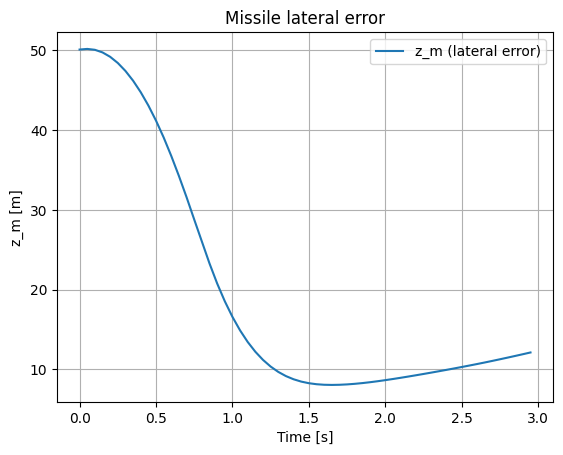

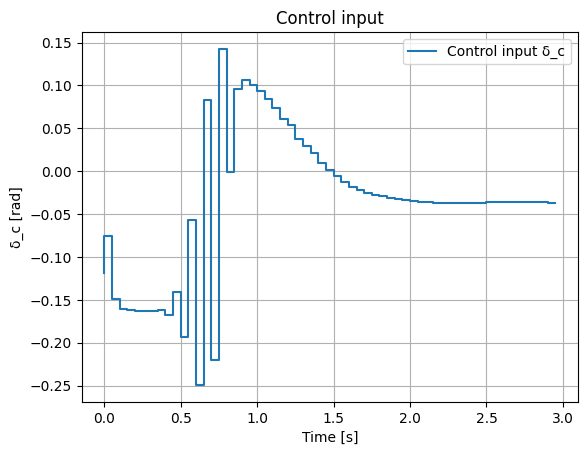

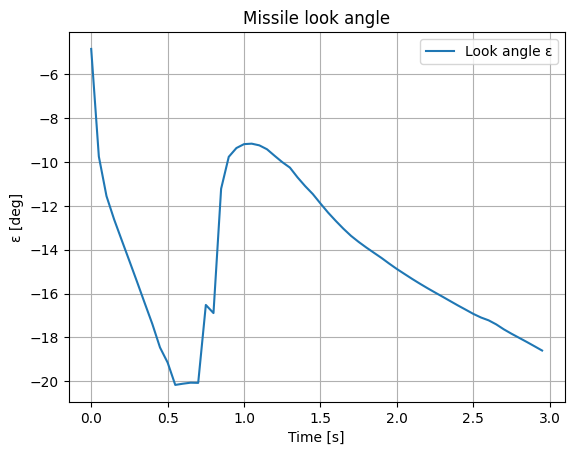

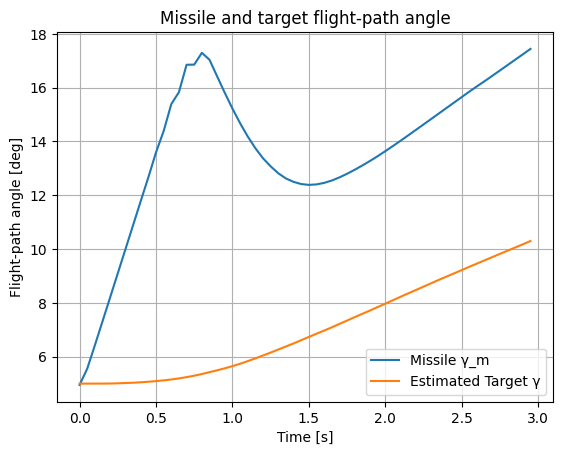

In [2]:
import cvxpy as cp
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

# ============================================================================
# 1. 기본 상수 및 파라미터 설정
# ============================================================================
g = 9.8067  # 표준 중력 [m/s^2]

# 미사일 파라미터 및 제약 (논문 Table 1 참고)
Para = {
    # --- 미사일 공력계수 ---
    "Z_alpha": -2.9399,     # [1/s]
    "Z_delta": -0.6497,     # [1/s]
    "M_alpha": -623.6149,   # [1/s^2]
    "M_q": -5.0,            # [1/s]
    "M_delta": -554.4808,   # [1/s^2]
    "omega_a": 100.0,       # 액추에이터 다이나믹스 (1/s)

    # --- 미사일 / 제약 ---
    "v_m": 380.0,           # 미사일 속도 (m/s)
    "a_m_max": 12.0 * g,    # 12 g
    "eps_max": np.deg2rad(20.0),  # 20° (라디안)

    # --- 시커 해상도 (예시) ---
    "S_fv": np.deg2rad(20.0),  # 시야각 (field of view) [rad]
    "S_r": 256,              # 해상도 (픽셀 수)

    # --- MPC 설정 ---
    "t_c": 3.0,              # 전체 유도종료시간 [s]
    "dt_c": 0.05             # 샘플링 간격 [s]
}

# 타깃 파라미터 (pull‐up maneuver 상황; 타깃은 일정 속도, 단위 가속도로 비행경로각이 변화)
Target_para = {
    "v_t": 380.0,           # 타깃 속도 [m/s]
    "gamma_t": np.deg2rad(5.0),         # 타깃 초기 비행경로각 [rad]
    "a_t": 3.0 * g          # 타깃 가속도 (pull‐up) [m/s^2]
}

# MPC 시간 지평 길이 (논문에서는 t_c = N * dt_c)
N_horizon = int(Para["t_c"] / Para["dt_c"])  # 예: 3.0/0.05 = 60

# ============================================================================
# 2. 함수 정의
# ============================================================================

# 2.1 연속시간 미사일 동적 모델 (식 (1) ~ (5))
def make_continuous_matrix(para, Target_para):
    # 상태 순서: [δₘ, αₘ, qₘ, γₘ, zₘ] (각각: 핀각, 받음각, 피치율, 비행경로각, 측면 오차)
    Continous_A = np.zeros((5, 5))
    Continous_B = np.zeros((5, 1))
    Continous_b = np.zeros((5, 1))
    # 식 (5)에서 Ā 행렬 (계수 행렬)
    Continous_A[0, 0] = -para["omega_a"]
    Continous_A[1, 0] = para["Z_delta"]
    Continous_A[1, 1] = para["Z_alpha"]
    Continous_A[1, 2] = 1.0
    Continous_A[2, 0] = para["M_delta"]
    Continous_A[2, 1] = para["M_alpha"]
    Continous_A[2, 2] = para["M_q"]
    # 4행: 미사일의 γₘ 동적 보정 (식 (4))
    Continous_A[3, 0] = -para["Z_delta"]
    Continous_A[3, 1] = -para["Z_alpha"]
    # 5행: zₘ 동적 (미사일의 lateral 오차; 식 (4))
    Continous_A[4, 3] = -para["v_m"]

    # 입력 매트릭스 B̄ (식 (5)) : δₘ 제어 입력의 계수
    Continous_B[0, 0] = para["omega_a"]

    # 항등항 b̄ : 타깃의 pull-up maneuver 효과, b̄의 마지막 원소는 v_t*sin(γₜ)
    # 단, MPC에서는 향후 비행경로각 예측을 위해 이 항은 이후 b̄_k로 재구성됨.
    Continous_b[-1, 0] = Target_para["v_t"] * np.sin(Target_para["gamma_t"])

    return Continous_A, Continous_B, Continous_b

# 2.2 연속-이산 변환 (식 (6))
def continuous_to_discrete_matrix(Continous_A, Continous_B, Continous_b, para):
    dt = para["dt_c"]
    A = expm(Continous_A * dt)
    n = 10
    m_dt = dt / n
    B_A = np.zeros_like(A)
    for i in range(n):
        B_A += (expm(Continous_A * m_dt * i) + expm(Continous_A * m_dt * (i + 1))) / 2 * m_dt
    B = B_A @ Continous_B
    b = B_A @ Continous_b
    return A, B, b, B_A  # B_A는 이후 b_k 계산에 사용

# 2.3 look angle 계산 (식 (7))
def look_angle(z_m, alpha_m, gamma_m, R):
    return z_m / R - alpha_m - gamma_m

# 2.4 Range-to-go 계산 (식 (9))
def range_to_go(R_0, para, Target_para, k):
    return R_0 - k * (para["v_m"] + Target_para["v_t"]) * para["dt_c"]

# 2.5 look angle 제약조건 행렬 (식 (8))
def look_angle_constraints(para, Range_k):
    # C_k: 4 x 5 행렬
    C_k = np.zeros((4, 5))
    C_k[0, :] = np.array([para["v_m"] * para["Z_delta"],
                           para["v_m"] * para["Z_alpha"],
                           0, 0, 0])
    C_k[1, :] = -C_k[0, :]
    C_k[2, :] = np.array([0, -1, 0, -1, 1 / Range_k])
    C_k[3, :] = -C_k[2, :]
    return C_k

# 2.6 MPC 문제 (식 (10))
# b_list: MPC 지평의 각 노드별로 예측한 b (b_k)를 리스트로 전달
def MPC(x_0, Q_k, Q_N, R_k_list, N, R_0, A, B, b_list, D, para, Target_para):
    nx = A.shape[0]
    nu = B.shape[1]
    x = cp.Variable((nx, N + 1))
    u = cp.Variable((nu, N))
    constraints = []
    cost = 0.0

    constraints.append(x[:, 0] == x_0.flatten())

    for k in range(N):
        cost += cp.quad_form(x[:, k], Q_k) + cp.quad_form(u[:, k], R_k_list[k])
        constraints.append(x[:, k + 1] == A @ x[:, k] + B @ u[:, k] + b_list[k])
        R_k_val = range_to_go(R_0, para, Target_para, k)
        C_k = look_angle_constraints(para, R_k_val)
        constraints.append(C_k @ x[:, k] <= D.flatten())
    cost += cp.quad_form(x[:, N], Q_N)

    prob = cp.Problem(cp.Minimize(cost), constraints)
    result = prob.solve(solver=cp.OSQP, eps_abs=1e-3, eps_rel=1e-3, max_iter=50000,verbose=True,warm_start=True)
    return x.value, u.value, result, prob.status

# 2.7 시커의 quantization 효과 (식 (12)) – 테스트용
def quantize_look_angle(e, para):
    S_fv = para["S_fv"]
    S_r = para["S_r"]
    quantum = S_fv / S_r
    return quantum * np.round(e / quantum)

# 2.8 타깃 측정: 미사일-타깃 상대 위치를 이용하여 look angle 측정 (식 (14))
def look_angle_noise(x_t, x_m, z_t, z_m, alpha_m, gamma_m, R_e):
    theta_m = pitch_angle(alpha_m, gamma_m)
    # 좌표 변환: 미사일 기준 타깃 상대 좌표
    dx = x_t - x_m
    dz = z_t - z_m
    u_val = np.cos(theta_m) * dx - np.sin(theta_m) * dz
    v_val = -np.sin(theta_m) * dx - np.cos(theta_m) * dz
    y = np.arctan2(v_val, u_val)
    y = quantize_look_angle(y, Para)
    noise = np.random.normal(0, R_e)
    return y + noise

# 2.9 미사일 pitch angle 계산 (식 (15))
def pitch_angle(alpha_m, gamma_m):
    return alpha_m + gamma_m

# 2.10 EKF 타깃 위치 추정 (식 (13), (14) 참고)
def ekf_target_estimator(x_est, P, z_meas, dt_e, Q_e, R_e, x_im, z_im, alpha_m, gamma_m):
    # 상태: [x_it, xdot_it, z_it, zdot_it]
    F = np.array([[1, dt_e, 0,    0],
                  [0,    1, 0,    0],
                  [0,    0, 1, dt_e],
                  [0,    0, 0,    1]])
    x_pred = F @ x_est
    P_pred = F @ P @ F.T + Q_e

    theta_m = pitch_angle(alpha_m, gamma_m)

    dx = x_pred[0] - x_im
    dz = x_pred[2] - z_im

    u_val = np.cos(theta_m) * dx - np.sin(theta_m) * dz
    v_val = -np.sin(theta_m) * dx - np.cos(theta_m) * dz

    h_pred = np.arctan2(v_val, u_val)
    y = z_meas - h_pred
    # 각도 랩핑: [-pi, pi]
    y = (y + np.pi) % (2 * np.pi) - np.pi

    denom = u_val**2 + v_val**2
    if denom < 1e-6:
        denom = 1e-6
    dh_dx = -(u_val * np.sin(theta_m) + v_val * np.cos(theta_m)) / denom
    dh_dz = -(u_val * np.cos(theta_m) - v_val * np.sin(theta_m)) / denom
    H = np.array([[dh_dx, 0, dh_dz, 0]])

    S = H @ P_pred @ H.T + R_e  # 스칼라
    K = P_pred @ H.T / S
    x_est_new = x_pred + (K * y).flatten()
    P_new = (np.eye(4) - K @ H) @ P_pred

    x_measure_k = x_est_new[0]
    z_measure_k = x_est_new[2]
    return x_est_new, P_new, x_measure_k, z_measure_k

# 2.11 비행경로각 추정: EKF 추정 결과의 속도 성분 이용 (np.arctan2)
def gamma_estimated(xdot, zdot):
    return np.arctan2(zdot, xdot)

# 2.12 다항식 평가 함수 (식 (19))
def p_t(t, p1, p2, p3):
    return p1 * t**2 + p2 * t + p3

# 2.13 다항식 최소자승 피팅 (식 (20))
def flight_path_angle_polyfit(t_values, gamma_hat):
    # 2차 다항식: p(t) = p1*t^2 + p2*t + p3
    coefficients = np.polyfit(t_values, gamma_hat, 2)  # [p1, p2, p3]
    return coefficients

# ============================================================================
# 3. 시뮬레이션 메인 루프
# ============================================================================

if __name__ == '__main__':
    # 3.1 초기 설정
    dt = Para["dt_c"]
    t_total = Para["t_c"]
    num_steps = int(t_total / dt)

    # 미사일 초기 상태: [δₘ, αₘ, qₘ, γₘ, zₘ]
    x_m = np.array([0.0, 0.0, 0.0, np.deg2rad(5.0), 50.0])
    # 미사일 초기 위치 (참조 좌표계에서; 초기 원점)
    x_im = 0.0
    z_im = 0.0

    # 타깃 초기 위치: 미사일과의 range R0 (예: 1000 m 후방)
    R0 = 1000.0
    true_x_t = x_im + R0
    true_z_t = 0.0
    true_gamma = Target_para["gamma_t"]  # 타깃 비행경로각

    # EKF 초기 상태: [x_it, xdot_it, z_it, zdot_it]
    x_est = np.array([true_x_t, Target_para["v_t"] * np.cos(true_gamma),
                      true_z_t, Target_para["v_t"] * np.sin(true_gamma)])
    P = np.eye(4) * 10.0  # 초기 공분산

    # EKF 및 측정 잡음 설정
    dt_e = dt  # EKF 시간 간격 (미사일과 동일)
    Q_e = np.eye(4) * 0.01  # 프로세스 노이즈 공분산
    R_e = np.deg2rad(0.5) ** 2  # 측정 노이즈 분산 (라디안^2)

    # MPC 관련 행렬 (비용 가중치)
    Q_k = np.diag([0.0, 0.0, 0.0, 0.0, 1.0])  # 주로 zₘ (lateral 오차)를 규제
    Q_N = Q_k.copy()
    R_weight = 0.01
    R_list = [np.array([[R_weight]]) for _ in range(N_horizon)]
    # 제약: [a_m_max, a_m_max, eps_max, eps_max]
    D = np.array([Para["a_m_max"], Para["a_m_max"], Para["eps_max"], Para["eps_max"]])

    # 미사일 연속시간 행렬 및 이산화 (항 b의 B_A 반환)
    Continous_A, Continous_B, Continous_b = make_continuous_matrix(Para, Target_para)
    A, B, b_const, B_A = continuous_to_discrete_matrix(Continous_A, Continous_B, Continous_b, Para)
    # b_const는 초기 b이지만, 이후 MPC에서는 예측된 비행경로각에 따라 b를 재구성할 것임

    # 비행경로각 예측을 위한 이력 저장
    t_hist = []
    gamma_hist = []

    # 기록을 위한 리스트
    time_record = []
    z_m_record = []       # 미사일 lateral 오차 (zₘ)
    u_record = []         # 제어 입력 (δ_c)
    look_angle_record = []  # 미사일의 look angle (ε)
    missile_pos_record = []  # (x_im, z_im)
    target_pos_record = []   # (true_x_t, true_z_t)
    gamma_m_record = []      # 미사일 비행경로각
    gamma_target_est_record = []  # EKF로 추정한 타깃 비행경로각

    # 시뮬레이션 루프
    for step in range(num_steps):
        t_current = step * dt

        # ---------------------------
        # (1) 타깃 진짜 상태 업데이트 (간단한 kinematic 모델)
        # ---------------------------
        # 타깃 비행경로각 업데이트: γ̇ = a_t / v_t
        true_gamma = true_gamma + (Target_para["a_t"] / Target_para["v_t"]) * dt
        # 타깃 속도 성분 (항상 일정 v_t)
        true_vx = Target_para["v_t"] * np.cos(true_gamma)
        true_vz = Target_para["v_t"] * np.sin(true_gamma)
        true_x_t = true_x_t + true_vx * dt
        true_z_t = true_z_t + true_vz * dt

        # ---------------------------
        # (2) 측정: 미사일 시점에서 타깃의 look angle 측정 (quantization 적용 가능)
        # ---------------------------
        # 미사일 현재 αₘ와 γₘ는 x_m[1]와 x_m[3]
        meas_look = look_angle_noise(true_x_t, x_im, true_z_t, z_im, x_m[1], x_m[3], R_e)
        # (필요시 quantization: quantize_look_angle(meas_look, Para))

        # ---------------------------
        # (3) EKF를 이용한 타깃 위치 추정
        # ---------------------------
        x_est, P, x_meas, z_meas = ekf_target_estimator(x_est, P, meas_look, dt_e, Q_e, R_e, x_im, z_im, x_m[1], x_m[3])
        # 타깃 추정 속도는 x_est[1] (xdot)와 x_est[3] (zdot)
        gamma_target_est = np.arctan2(x_est[3], x_est[1])
        # 이력을 저장 (비행경로각 예측에 사용)
        t_hist.append(t_current)
        gamma_hist.append(gamma_target_est)

        # ---------------------------
        # (4) 비행경로각 예측 (다항식 피팅)
        # ---------------------------
        # 충분한 데이터가 있으면 (최소 3개 이상) 다항식 피팅, 아니면 현재 추정값을 상수로 사용
        if len(t_hist) >= 3:
            coeffs = flight_path_angle_polyfit(np.array(t_hist), np.array(gamma_hist))
            # coeffs = [p1, p2, p3]
            # 예측시간: 현재 t부터 t + (N_horizon-1)*dt
            pred_times = np.array([t_current + k * dt for k in range(N_horizon)])
            predicted_gamma = np.polyval(coeffs, pred_times)
        else:
            predicted_gamma = np.full(N_horizon, gamma_target_est)

        # ---------------------------
        # (5) MPC를 위한 각 시점별 b_k 계산
        # ---------------------------
        b_list = []
        for k in range(N_horizon):
            # b̄_k = [0, 0, 0, 0, v_t * sin(predicted_gamma[k])]
            b_bar_k = np.array([[0.0], [0.0], [0.0], [0.0],
                                  [Target_para["v_t"] * np.sin(predicted_gamma[k])]])
            b_k = B_A @ b_bar_k
            b_list.append(b_k.flatten())

        # ---------------------------
        # (6) 현재 미사일-타깃 range 계산 (x축 상 거리)
        # ---------------------------
        current_R = true_x_t - x_im

        # ---------------------------
        # (7) MPC 최적화 문제 해결
        # ---------------------------
        x_opt, u_opt, mpc_result, status = MPC(x_m, Q_k, Q_N, R_list, N_horizon, current_R, A, B, b_list, D, Para, Target_para)
        if status != cp.OPTIMAL and status != cp.OPTIMAL_INACCURATE:
            print(f"MPC 문제 해결 실패 at t={t_current:.2f}")
            break
        u_mpc = u_opt[:, 0]  # 첫 번째 제어입력을 사용 (δ_c)

        # ---------------------------
        # (8) 미사일 실제 동적 업데이트
        # ---------------------------
        # 실제 미사일 동적에서는 b 항은 타깃의 실제 γ (true_gamma)를 사용하여 계산
        b_bar_actual = np.array([[0.0], [0.0], [0.0], [0.0],
                                 [Target_para["v_t"] * np.sin(true_gamma)]])
        b_actual = B_A @ b_bar_actual
        x_m = A @ x_m + B @ u_mpc + b_actual.flatten()

        # ---------------------------
        # (9) 미사일 위치 업데이트 (단, 속도는 상수 v_m, 비행경로각은 x_m[3])
        # ---------------------------
        gamma_m = x_m[3]
        x_im = x_im + Para["v_m"] * np.cos(gamma_m) * dt
        z_im = z_im + Para["v_m"] * np.sin(gamma_m) * dt

        # ---------------------------
        # (10) 기록 저장
        # ---------------------------
        time_record.append(t_current)
        z_m_record.append(x_m[4])   # 미사일 lateral 오차
        u_record.append(u_mpc[0])
        # look angle (ε) 계산: ε = zₘ/R - αₘ - γₘ
        look_angle_val = look_angle(x_m[4], x_m[1], x_m[3], current_R)
        look_angle_record.append(look_angle_val)
        missile_pos_record.append((x_im, z_im))
        target_pos_record.append((true_x_t, true_z_t))
        gamma_m_record.append(x_m[3])
        gamma_target_est_record.append(gamma_target_est)

    # ============================================================================
    # 4. 시뮬레이션 결과 플롯
    # ============================================================================

    time_record = np.array(time_record)
    z_m_record = np.array(z_m_record)
    u_record = np.array(u_record)
    look_angle_record = np.array(look_angle_record)
    gamma_m_record = np.array(gamma_m_record)
    gamma_target_est_record = np.array(gamma_target_est_record)

    # 미사일 lateral 오차 (z_m) 플롯

    plt.figure()
    plt.plot(time_record, z_m_record, label='z_m (lateral error)')
    plt.xlabel("Time [s]")
    plt.ylabel("z_m [m]")
    plt.title("Missile lateral error")
    plt.grid(True)
    plt.legend()

    # Control input (δ_c) plot
    plt.figure()
    plt.step(time_record, u_record, label='Control input δ_c')
    plt.xlabel("Time [s]")
    plt.ylabel("δ_c [rad]")
    plt.title("Control input")
    plt.grid(True)
    plt.legend()

    # Look angle (ε) plot (unit: deg)
    plt.figure()
    plt.plot(time_record, np.rad2deg(look_angle_record), label='Look angle ε')
    plt.xlabel("Time [s]")
    plt.ylabel("ε [deg]")
    plt.title("Missile look angle")
    plt.grid(True)
    plt.legend()

    # Missile and target flight-path angle plot (deg)
    plt.figure()
    plt.plot(time_record, np.rad2deg(gamma_m_record), label='Missile γ_m')
    plt.plot(time_record, np.rad2deg(gamma_target_est_record), label='Estimated Target γ')
    plt.xlabel("Time [s]")
    plt.ylabel("Flight-path angle [deg]")
    plt.title("Missile and target flight-path angle")
    plt.grid(True)
    plt.legend()

    plt.show()



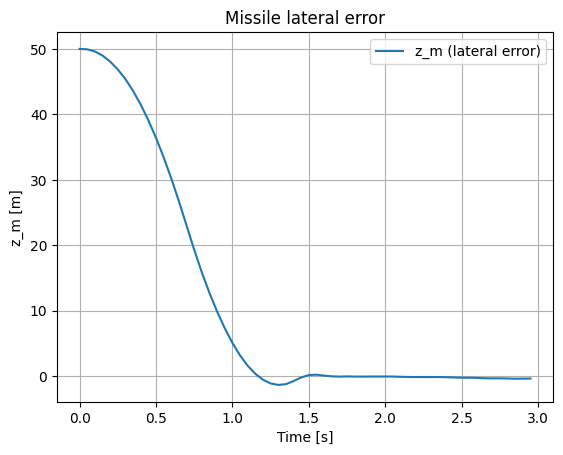

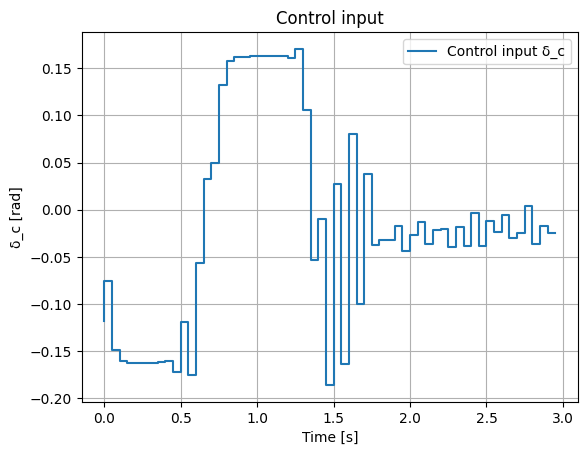

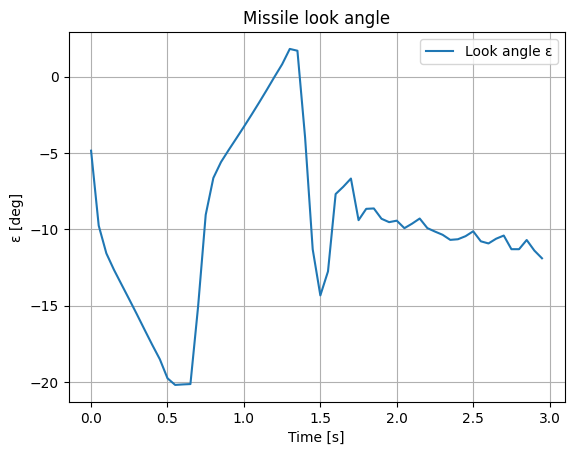

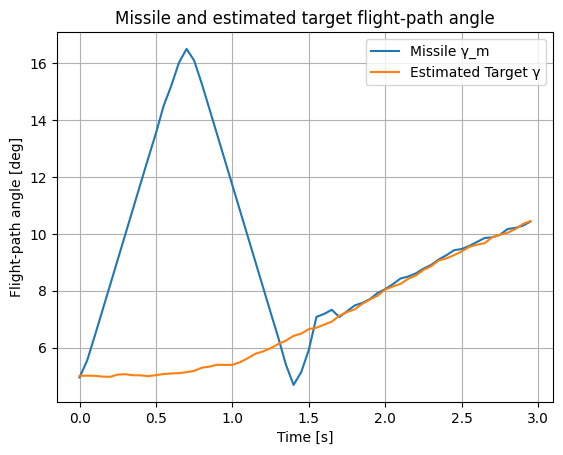

In [3]:
import cvxpy as cp
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

# ============================================================================
# 1. 기본 상수 및 파라미터 설정
# ============================================================================
g = 9.8067  # 표준 중력 [m/s^2]

# 미사일 파라미터 및 제약 (논문 Table 1 참고)
Para = {
    # --- 미사일 공력계수 ---
    "Z_alpha": -2.9399,     # [1/s]
    "Z_delta": -0.6497,     # [1/s]
    "M_alpha": -623.6149,   # [1/s^2]
    "M_q": -5.0,            # [1/s]
    "M_delta": -554.4808,   # [1/s^2]
    "omega_a": 100.0,       # 액추에이터 다이나믹스 (1/s)

    # --- 미사일 / 제약 ---
    "v_m": 380.0,           # 미사일 속도 (m/s)
    "a_m_max": 12.0 * g,    # 12 g
    "eps_max": np.deg2rad(20.0),  # 20° (라디안)

    # --- 시커 해상도 (예시) ---
    "S_fv": np.deg2rad(20.0),  # 시야각 (field of view) [rad]
    "S_r": 256,                # 해상도 (픽셀 수)

    # --- MPC 설정 ---
    "t_c": 3.0,                # 전체 유도종료시간 [s]
    "dt_c": 0.05               # 샘플링 간격 [s]
}

# 타깃 파라미터 (pull‐up maneuver 상황; 타깃은 일정 속도, 단위 가속도로 비행경로각이 변화)
Target_para = {
    "v_t": 380.0,                        # 타깃 속도 [m/s]
    "gamma_t": np.deg2rad(5.0),          # 타깃 초기 비행경로각 [rad]
    "a_t": 3.0 * g                       # 타깃 가속도 (pull‐up) [m/s^2]
}

# MPC 시간 지평 길이 (논문에서는 t_c = N * dt_c)
N_horizon = int(Para["t_c"] / Para["dt_c"])  # 예: 3.0/0.05 = 60

# ============================================================================
# 2. 함수 정의
# ============================================================================

# 2.1 연속시간 미사일 동적 모델 (식 (1) ~ (5))
def make_continuous_matrix(para, Target_para):
    # 상태 순서: [δₘ, αₘ, qₘ, γₘ, zₘ]
    Continous_A = np.zeros((5, 5))
    Continous_B = np.zeros((5, 1))
    Continous_b = np.zeros((5, 1))
    # 식 (5)에서 Ā 행렬
    Continous_A[0, 0] = -para["omega_a"]
    Continous_A[1, 0] = para["Z_delta"]
    Continous_A[1, 1] = para["Z_alpha"]
    Continous_A[1, 2] = 1.0
    Continous_A[2, 0] = para["M_delta"]
    Continous_A[2, 1] = para["M_alpha"]
    Continous_A[2, 2] = para["M_q"]
    # 4행: 미사일의 γₘ 동적 보정
    Continous_A[3, 0] = -para["Z_delta"]
    Continous_A[3, 1] = -para["Z_alpha"]
    # 5행: zₘ 동적 (미사일 lateral 오차; 식 (4))
    Continous_A[4, 3] = -para["v_m"]

    # 입력 매트릭스 B̄ : δₘ 제어 입력의 계수
    Continous_B[0, 0] = para["omega_a"]

    # 항등항 b̄ : 타깃의 pull-up maneuver 효과
    #   여기서는 마지막 행 (z_dot)에 타깃 속도 성분이 들어감.
    #   이후 MPC에서 타깃 γ(t)에 따라 계속 업데이트할 것이므로 초기값만 세팅
    Continous_b[-1, 0] = Target_para["v_t"] * np.sin(Target_para["gamma_t"])

    return Continous_A, Continous_B, Continous_b

# 2.2 연속-이산 변환 (식 (6))
def continuous_to_discrete_matrix(Continous_A, Continous_B, Continous_b, para):
    dt = para["dt_c"]
    A = expm(Continous_A * dt)
    n = 10  # 세분화 적분을 위한 분할 횟수
    m_dt = dt / n
    B_A = np.zeros_like(A)
    for i in range(n):
        # 사다리꼴 적분 근사
        B_A += (expm(Continous_A * m_dt * i) + expm(Continous_A * m_dt * (i + 1))) / 2 * m_dt

    B = B_A @ Continous_B
    b = B_A @ Continous_b
    return A, B, b, B_A  # B_A는 이후 b_k 계산에 사용

# 2.3 look angle 계산 (식 (7))
def look_angle(z_m, alpha_m, gamma_m, R):
    # ε = zₘ / R - αₘ - γₘ
    return z_m / R - alpha_m - gamma_m

# 2.4 Range-to-go 계산 (식 (9))
def range_to_go(R_0, para, Target_para, k):
    # R_k = R_0 - k * (v_m + v_t)*dt_c
    return R_0 - k * (para["v_m"] + Target_para["v_t"]) * para["dt_c"]

# 2.5 look angle 제약조건 행렬 (식 (8))
def look_angle_constraints(para, Range_k):
    # C_k: 4 x 5 행렬, D: [a_m_max, a_m_max, eps_max, eps_max]
    C_k = np.zeros((4, 5))
    C_k[0, :] = np.array([para["v_m"] * para["Z_delta"],
                          para["v_m"] * para["Z_alpha"],
                          0, 0, 0])
    C_k[1, :] = -C_k[0, :]
    C_k[2, :] = np.array([0, -1, 0, -1, 1 / Range_k])
    C_k[3, :] = -C_k[2, :]
    return C_k

# 2.6 MPC 문제 (식 (10))
def MPC(x_0, Q_k, Q_N, R_k_list, N, R_0, A, B, b_list, D, para, Target_para):
    nx = A.shape[0]
    nu = B.shape[1]
    x = cp.Variable((nx, N + 1))
    u = cp.Variable((nu, N))
    constraints = []
    cost = 0.0

    # 초기조건
    constraints.append(x[:, 0] == x_0.flatten())

    for k in range(N):
        cost += cp.quad_form(x[:, k], Q_k) + cp.quad_form(u[:, k], R_k_list[k])
        constraints.append(x[:, k + 1] == A @ x[:, k] + B @ u[:, k] + b_list[k])

        # look angle 제약
        R_k_val = range_to_go(R_0, para, Target_para, k)
        C_k = look_angle_constraints(para, R_k_val)
        constraints.append(C_k @ x[:, k] <= D.flatten())

    # 종단비용
    cost += cp.quad_form(x[:, N], Q_N)

    # OSQP로 풀이 (QP 문제)
    prob = cp.Problem(cp.Minimize(cost), constraints)
    result = prob.solve(solver=cp.OSQP, eps_abs=1e-3, eps_rel=1e-3,
                        max_iter=50000, verbose=False, warm_start=True)
    return x.value, u.value, result, prob.status

# 2.7 시커의 quantization 효과 (식 (12)) – 필요시 적용
def quantize_look_angle(e, para):
    S_fv = para["S_fv"]
    S_r = para["S_r"]
    quantum = S_fv / S_r
    return quantum * np.round(e / quantum)

# 2.8 타깃 측정: 미사일-타깃 상대 위치를 이용하여 look angle 측정 (식 (14))
def look_angle_noise(x_t, x_m, z_t, z_m, alpha_m, gamma_m, R_e):
    # 미사일의 pitch angle = alpha_m + gamma_m
    theta_m = pitch_angle(alpha_m, gamma_m)
    # 미사일 기준 좌표계로 변환
    dx = x_t - x_m
    dz = z_t - z_m
    u_val = np.cos(theta_m) * dx - np.sin(theta_m) * dz
    v_val = -np.sin(theta_m) * dx - np.cos(theta_m) * dz

    # 측정 각
    y = np.arctan2(v_val, u_val)

    # 양자화 (필요 시 적용) -> y = quantize_look_angle(y, para)
    # 여기서는 아래 한 줄만 노이즈 적용
    noise = np.random.normal(0, R_e**0.5)  # R_e는 분산
    return y + noise

# 2.9 미사일 pitch angle 계산 (식 (15))
def pitch_angle(alpha_m, gamma_m):
    return alpha_m + gamma_m

# 2.10 EKF 타깃 위치 추정 (식 (13), (14) 참고)
def ekf_target_estimator(x_est, P, z_meas, dt_e, Q_e, R_e, x_im, z_im, alpha_m, gamma_m):
    """
    상태: [x_it, xdot_it, z_it, zdot_it]
    - x_it, z_it: 타깃 위치 추정
    - xdot_it, zdot_it: 타깃 속도 추정
    """
    # 1) 예측단계
    F = np.array([[1, dt_e, 0,    0],
                  [0,    1,  0,    0],
                  [0,    0,  1, dt_e],
                  [0,    0,  0,    1]])
    x_pred = F @ x_est
    P_pred = F @ P @ F.T + Q_e

    # 2) 측정 - 시커가 측정하는 것은 미사일 기준의 각(look angle)
    theta_m = pitch_angle(alpha_m, gamma_m)
    dx = x_pred[0] - x_im
    dz = x_pred[2] - z_im
    u_val = np.cos(theta_m) * dx - np.sin(theta_m) * dz
    v_val = -np.sin(theta_m) * dx - np.cos(theta_m) * dz

    # 예측 측정값
    h_pred = np.arctan2(v_val, u_val)

    # 실제 측정과 비교
    y = z_meas - h_pred
    # 각도 래핑(−π ~ π 사이로 보정)
    y = (y + np.pi) % (2 * np.pi) - np.pi

    denom = u_val**2 + v_val**2
    if denom < 1e-6:
        denom = 1e-6

    # h_pred = arctan2(v, u)
    # ∂h/∂x = ...
    dh_dx = -(u_val * np.sin(theta_m) + v_val * np.cos(theta_m)) / denom
    dh_dz = -(u_val * np.cos(theta_m) - v_val * np.sin(theta_m)) / denom
    # z_meas는 하나의 scalar이므로, H는 1x4
    H = np.array([[dh_dx, 0, dh_dz, 0]])

    # 3) 갱신단계
    S = H @ P_pred @ H.T + R_e  # 스칼라
    K = P_pred @ H.T / S
    x_est_new = x_pred + (K * y).flatten()
    P_new = (np.eye(4) - K @ H) @ P_pred

    # 모니터링용 (추정된 x, z)
    x_measure_k = x_est_new[0]
    z_measure_k = x_est_new[2]
    return x_est_new, P_new, x_measure_k, z_measure_k

# 2.11 비행경로각 추정: EKF 추정 결과의 속도 성분 이용
def gamma_estimated(xdot, zdot):
    return np.arctan2(zdot, xdot)

# 2.12 다항식 평가 함수 (p(t) = p1 * t^2 + p2 * t + p3)
def p_t(t, p1, p2, p3):
    return p1 * t**2 + p2 * t + p3

# 2.13 다항식 최소자승 피팅 (2차 다항식)
def flight_path_angle_polyfit(t_values, gamma_hat):
    coefficients = np.polyfit(t_values, gamma_hat, 2)  # [p1, p2, p3]
    return coefficients

# ============================================================================
# 3. 시뮬레이션 메인 루프
# ============================================================================
if __name__ == '__main__':
    # 3.1 초기 설정
    dt = Para["dt_c"]
    t_total = Para["t_c"]
    num_steps = int(t_total / dt)

    # 미사일 초기 상태: [δₘ, αₘ, qₘ, γₘ, zₘ]
    x_m = np.array([0.0, 0.0, 0.0, np.deg2rad(5.0), 50.0])
    # 미사일 초기 위치 (지면 좌표계)
    x_im = 0.0
    z_im = 0.0

    # 타깃 초기 상태(지면 좌표계)
    R0 = 1000.0  # 미사일로부터 1000 m 앞에 있다고 가정
    true_x_t = x_im + R0
    true_z_t = 0.0
    true_gamma = Target_para["gamma_t"]  # 타깃 비행경로각(참값)

    # EKF 초기 상태: [x_it, xdot_it, z_it, zdot_it]
    x_est = np.array([true_x_t,
                      Target_para["v_t"] * np.cos(true_gamma),
                      true_z_t,
                      Target_para["v_t"] * np.sin(true_gamma)])
    P = np.eye(4) * 10.0  # 초기 공분산

    # EKF 잡음 설정
    dt_e = dt            # EKF 주기
    Q_e = np.eye(4) * 0.01
    R_e = np.deg2rad(0.5) ** 2  # 측정 노이즈 분산 (라디안^2)

    # MPC 관련 행렬 (비용 가중치)
    Q_k = np.diag([0.0, 0.0, 0.0, 0.0, 1.0])  # zₘ 오차에 가중
    Q_N = Q_k.copy()
    R_weight = 0.01
    R_list = [np.array([[R_weight]]) for _ in range(N_horizon)]
    # 제약: [a_m_max, a_m_max, eps_max, eps_max]
    D = np.array([Para["a_m_max"], Para["a_m_max"], Para["eps_max"], Para["eps_max"]])

    # 미사일 연속시간 행렬 및 이산화
    Continous_A, Continous_B, Continous_b = make_continuous_matrix(Para, Target_para)
    A, B, b_const, B_A = continuous_to_discrete_matrix(Continous_A, Continous_B, Continous_b, Para)

    # 타깃 비행경로각 예측을 위한 데이터 저장 (EKF 결과 이용)
    t_hist = []
    gamma_hist = []

    # 기록용 리스트
    time_record = []
    z_m_record = []
    u_record = []
    look_angle_record = []
    missile_pos_record = []
    target_pos_record = []
    gamma_m_record = []
    gamma_target_est_record = []

    # 시뮬레이션 루프
    for step in range(num_steps):
        t_current = step * dt

        # ---------------------------
        # (1) 타깃 '진짜' 상태 업데이트 (가상의 참값 시뮬레이션)
        # ---------------------------
        # 타깃 비행경로각 업데이트: gamma_dot = a_t / v_t
        true_gamma += (Target_para["a_t"] / Target_para["v_t"]) * dt
        true_vx = Target_para["v_t"] * np.cos(true_gamma)
        true_vz = Target_para["v_t"] * np.sin(true_gamma)
        true_x_t += true_vx * dt
        true_z_t += true_vz * dt

        # ---------------------------
        # (2) 측정: 미사일 시점에서 타깃의 look angle 측정
        # ---------------------------
        meas_look = look_angle_noise(true_x_t, x_im, true_z_t, z_im,
                                     x_m[1], x_m[3], R_e)

        # ---------------------------
        # (3) EKF를 이용한 타깃 위치 추정
        # ---------------------------
        x_est, P, x_meas, z_meas = ekf_target_estimator(
            x_est, P, meas_look, dt_e, Q_e, R_e,
            x_im, z_im, x_m[1], x_m[3]
        )
        # 추정된 타깃 비행경로각
        gamma_target_est = gamma_estimated(x_est[1], x_est[3])

        # ---------------------------
        # (4) 타깃 비행경로각 예측 (2차 다항식 피팅)
        # ---------------------------
        t_hist.append(t_current)
        gamma_hist.append(gamma_target_est)

        if len(t_hist) >= 3:
            # 최소 3점 이상일 때 2차 피팅
            coeffs = flight_path_angle_polyfit(np.array(t_hist),
                                               np.array(gamma_hist))
            pred_times = np.array([t_current + k * dt for k in range(N_horizon)])
            predicted_gamma = np.polyval(coeffs, pred_times)
        else:
            # 초기에는 데이터가 적으므로 현재값으로 고정
            predicted_gamma = np.full(N_horizon, gamma_target_est)

        # ---------------------------
        # (5) MPC를 위한 b_list 계산
        #     b_bar_k = [0, 0, 0, 0, v_t * sin( gamma_pred )]
        # ---------------------------
        b_list = []
        for k in range(N_horizon):
            b_bar_k = np.array([[0.0],
                                [0.0],
                                [0.0],
                                [0.0],
                                [Target_para["v_t"] * np.sin(predicted_gamma[k])]])
            b_k = B_A @ b_bar_k
            b_list.append(b_k.flatten())

        # ---------------------------
        # (6) 현재 미사일-타깃 거리(R) 계산 (x축상 거리 단순 가정)
        # ---------------------------
        current_R = true_x_t - x_im

        # ---------------------------
        # (7) MPC 최적화 문제 해결
        # ---------------------------
        x_opt, u_opt, mpc_result, status = MPC(x_m, Q_k, Q_N, R_list,
                                               N_horizon, current_R,
                                               A, B, b_list, D,
                                               Para, Target_para)
        if status not in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
            print(f"MPC 문제 해결 실패 at t={t_current:.2f}")
            break
        u_mpc = u_opt[:, 0]  # 첫 번째 스텝의 제어입력 사용

        # ---------------------------
        # (8) 미사일 실제 동적 업데이트
        #     -> EKF 추정한 gamma_target_est 사용
        # ---------------------------
        b_bar_actual = np.array([[0.0],
                                 [0.0],
                                 [0.0],
                                 [0.0],
                                 [Target_para["v_t"] * np.sin(gamma_target_est)]])
        b_actual = B_A @ b_bar_actual
        x_m = A @ x_m + B @ u_mpc + b_actual.flatten()

        # ---------------------------
        # (9) 미사일 위치 업데이트
        # ---------------------------
        gamma_m = x_m[3]
        x_im += Para["v_m"] * np.cos(gamma_m) * dt
        z_im += Para["v_m"] * np.sin(gamma_m) * dt

        # ---------------------------
        # (10) 결과 기록
        # ---------------------------
        time_record.append(t_current)
        z_m_record.append(x_m[4])
        u_record.append(u_mpc[0])

        # look angle 기록
        look_angle_val = look_angle(x_m[4], x_m[1], x_m[3], current_R)
        look_angle_record.append(look_angle_val)

        missile_pos_record.append((x_im, z_im))
        target_pos_record.append((true_x_t, true_z_t))
        gamma_m_record.append(gamma_m)
        gamma_target_est_record.append(gamma_target_est)

    # ============================================================================
    # 4. 결과 플롯
    # ============================================================================
    time_record = np.array(time_record)
    z_m_record = np.array(z_m_record)
    u_record = np.array(u_record)
    look_angle_record = np.array(look_angle_record)
    gamma_m_record = np.array(gamma_m_record)
    gamma_target_est_record = np.array(gamma_target_est_record)

    # 미사일 lateral 오차 (z_m)
    plt.figure()
    plt.plot(time_record, z_m_record, label='z_m (lateral error)')
    plt.xlabel("Time [s]")
    plt.ylabel("z_m [m]")
    plt.title("Missile lateral error")
    plt.grid(True)
    plt.legend()

    # Control input (δ_c)
    plt.figure()
    plt.step(time_record, u_record, label='Control input δ_c')
    plt.xlabel("Time [s]")
    plt.ylabel("δ_c [rad]")
    plt.title("Control input")
    plt.grid(True)
    plt.legend()

    # Look angle (ε) (deg)
    plt.figure()
    plt.plot(time_record, np.rad2deg(look_angle_record), label='Look angle ε')
    plt.xlabel("Time [s]")
    plt.ylabel("ε [deg]")
    plt.title("Missile look angle")
    plt.grid(True)
    plt.legend()

    # Missile & Target flight-path angle (deg)
    plt.figure()
    plt.plot(time_record, np.rad2deg(gamma_m_record), label='Missile γ_m')
    plt.plot(time_record, np.rad2deg(gamma_target_est_record), label='Estimated Target γ')
    plt.xlabel("Time [s]")
    plt.ylabel("Flight-path angle [deg]")
    plt.title("Missile and estimated target flight-path angle")
    plt.grid(True)
    plt.legend()

    plt.show()


In [5]:
import cvxpy as cp
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

g = 9.8067  # 표준 중력 [m/s^2]

Para = {
    "Z_alpha": -2.9399,     # [1/s]
    "Z_delta": -0.6497,     # [1/s]
    "M_alpha": -623.6149,   # [1/s^2]
    "M_q": -5.0,            # [1/s]
    "M_delta": -554.4808,   # [1/s^2]
    "omega_a": 100.0,       # 액추에이터 다이나믹스 (1/s)

    "v_m": 380.0,
    "a_m_max": 12.0 * g,
    "eps_max": np.deg2rad(20.0),

    "S_fv": np.deg2rad(20.0),
    "S_r": 256,

    # MPC 시간 파라미터
    "t_c": 3.0,
    "dt_c": 0.05
}

Target_para = {
    "v_t": 380.0,
    "gamma_t": np.deg2rad(5.0),
    "a_t": 3.0 * g
}

N_horizon = int(Para["t_c"] / Para["dt_c"])

def make_continuous_matrix(para, Target_para):
    Continous_A = np.zeros((5, 5))
    Continous_B = np.zeros((5, 1))
    Continous_b = np.zeros((5, 1))
    # Ā
    Continous_A[0, 0] = -para["omega_a"]
    Continous_A[1, 0] = para["Z_delta"]
    Continous_A[1, 1] = para["Z_alpha"]
    Continous_A[1, 2] = 1.0
    Continous_A[2, 0] = para["M_delta"]
    Continous_A[2, 1] = para["M_alpha"]
    Continous_A[2, 2] = para["M_q"]
    Continous_A[3, 0] = -para["Z_delta"]
    Continous_A[3, 1] = -para["Z_alpha"]
    Continous_A[4, 3] = -para["v_m"]
    # B̄
    Continous_B[0, 0] = para["omega_a"]
    # b̄
    Continous_b[-1, 0] = Target_para["v_t"] * np.sin(Target_para["gamma_t"])
    return Continous_A, Continous_B, Continous_b

def continuous_to_discrete_matrix(Continous_A, Continous_B, Continous_b, para):
    dt = para["dt_c"]
    A = expm(Continous_A * dt)
    n = 10
    m_dt = dt / n
    B_A = np.zeros_like(A)
    for i in range(n):
        B_A += (expm(Continous_A * m_dt * i) + expm(Continous_A * m_dt * (i + 1))) / 2 * m_dt
    B = B_A @ Continous_B
    b = B_A @ Continous_b
    return A, B, b, B_A

def look_angle(z_m, alpha_m, gamma_m, R):
    return z_m / R - alpha_m - gamma_m

def range_to_go(R_0, para, Target_para, k):
    return R_0 - k * (para["v_m"] + Target_para["v_t"]) * para["dt_c"]

def look_angle_constraints(para, Range_k):
    C_k = np.zeros((4, 5))
    C_k[0, :] = np.array([para["v_m"] * para["Z_delta"],
                          para["v_m"] * para["Z_alpha"],
                          0, 0, 0])
    C_k[1, :] = -C_k[0, :]
    C_k[2, :] = np.array([0, -1, 0, -1, 1 / Range_k])
    C_k[3, :] = -C_k[2, :]
    return C_k

def MPC(x_0, Q_k, Q_N, R_k_list, N, R_0, A, B, b_list, D, para, Target_para):
    nx = A.shape[0]
    nu = B.shape[1]
    x = cp.Variable((nx, N + 1))
    u = cp.Variable((nu, N))
    constraints = []
    cost = 0.0

    constraints.append(x[:, 0] == x_0.flatten())

    for k in range(N):
        cost += cp.quad_form(x[:, k], Q_k) + cp.quad_form(u[:, k], R_k_list[k])
        constraints.append(x[:, k + 1] == A @ x[:, k] + B @ u[:, k] + b_list[k])

        R_k_val = range_to_go(R_0, para, Target_para, k)
        C_k = look_angle_constraints(para, R_k_val)
        constraints.append(C_k @ x[:, k] <= D.flatten())
    cost += cp.quad_form(x[:, N], Q_N)

    prob = cp.Problem(cp.Minimize(cost), constraints)
    result = prob.solve(solver=cp.OSQP, eps_abs=1e-3, eps_rel=1e-3,
                        max_iter=100000, verbose=False, warm_start=True)
    return x.value, u.value, result, prob.status

def look_angle_noise(x_t, x_m, z_t, z_m, alpha_m, gamma_m, R_var):
    # R_var: 측정 노이즈 분산
    theta_m = alpha_m + gamma_m
    dx = x_t - x_m
    dz = z_t - z_m
    u_val = np.cos(theta_m) * dx - np.sin(theta_m) * dz
    v_val = -np.sin(theta_m) * dx - np.cos(theta_m) * dz
    h = np.arctan2(v_val, u_val)
    noise = np.random.normal(0, np.sqrt(R_var))
    return h + noise

def pitch_angle(alpha_m, gamma_m):
    return alpha_m + gamma_m

def ekf_target_estimator(x_est, P, z_meas, dt_e, Q_e, R_e, x_im, z_im, alpha_m, gamma_m):
    F = np.array([[1, dt_e, 0,    0],
                  [0,    1,  0,    0],
                  [0,    0,  1, dt_e],
                  [0,    0,  0,    1]])
    x_pred = F @ x_est
    P_pred = F @ P @ F.T + Q_e

    theta_m = pitch_angle(alpha_m, gamma_m)
    dx = x_pred[0] - x_im
    dz = x_pred[2] - z_im
    u_val = np.cos(theta_m) * dx - np.sin(theta_m) * dz
    v_val = -np.sin(theta_m) * dx - np.cos(theta_m) * dz
    h_pred = np.arctan2(v_val, u_val)

    y = z_meas - h_pred
    y = (y + np.pi) % (2 * np.pi) - np.pi

    denom = u_val**2 + v_val**2
    if denom < 1e-6:
        denom = 1e-6
    dh_dx = -(u_val * np.sin(theta_m) + v_val * np.cos(theta_m)) / denom
    dh_dz = -(u_val * np.cos(theta_m) - v_val * np.sin(theta_m)) / denom
    H = np.array([[dh_dx, 0, dh_dz, 0]])

    S = H @ P_pred @ H.T + R_e
    K = P_pred @ H.T / S
    x_est_new = x_pred + (K * y).flatten()
    P_new = (np.eye(4) - K @ H) @ P_pred
    return x_est_new, P_new, x_est_new[0], x_est_new[2]

def gamma_estimated(xdot, zdot):
    return np.arctan2(zdot, xdot)

def flight_path_angle_polyfit(t_values, gamma_hat):
    # 2차 다항식 피팅
    coefficients = np.polyfit(t_values, gamma_hat, 2)
    return coefficients

# ------------------------------------------------------------------------
# 단일 시뮬레이션을 수행하는 함수를 정의
# ------------------------------------------------------------------------
def run_simulation(random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    dt = Para["dt_c"]
    t_total = Para["t_c"]
    num_steps = int(t_total / dt)

    # 초기화
    x_m = np.array([0.0, 0.0, 0.0, np.deg2rad(5.0), 50.0])
    x_im = 0.0
    z_im = 0.0
    R0 = 1000.0
    true_x_t = x_im + R0
    true_z_t = 0.0
    true_gamma = Target_para["gamma_t"]

    x_est = np.array([true_x_t,
                      Target_para["v_t"]*np.cos(true_gamma),
                      true_z_t,
                      Target_para["v_t"]*np.sin(true_gamma)])
    P = np.eye(4)*10.0

    dt_e = dt
    Q_e = np.eye(4)*0.01
    R_e = np.deg2rad(0.5)**2

    Q_k = np.diag([0,0,0,0,1.0])
    Q_N = Q_k.copy()
    R_weight = 0.01
    R_list = [np.array([[R_weight]]) for _ in range(N_horizon)]
    D = np.array([Para["a_m_max"], Para["a_m_max"],
                  Para["eps_max"], Para["eps_max"]])

    Continous_A, Continous_B, Continous_b = make_continuous_matrix(Para, Target_para)
    A, B, b_const, B_A = continuous_to_discrete_matrix(Continous_A,
                                                       Continous_B,
                                                       Continous_b,
                                                       Para)

    t_hist = []
    gamma_hist = []

    time_record = []
    z_m_record = []
    u_record = []
    look_angle_record = []
    gamma_m_record = []
    gamma_target_est_record = []

    x_pos_record = []
    z_pos_record = []
    x_tgt_record = []
    z_tgt_record = []

    for step in range(num_steps):
        t_current = step*dt

        # (1) 타깃 참값 업데이트
        true_gamma += (Target_para["a_t"] / Target_para["v_t"]) * dt
        vx_t = Target_para["v_t"]*np.cos(true_gamma)
        vz_t = Target_para["v_t"]*np.sin(true_gamma)
        true_x_t += vx_t*dt
        true_z_t += vz_t*dt

        # (2) 시커 측정
        meas_look = look_angle_noise(true_x_t, x_im,
                                     true_z_t, z_im,
                                     x_m[1], x_m[3],
                                     R_e)

        # (3) EKF
        x_est, P, _, _ = ekf_target_estimator(x_est, P, meas_look, dt_e, Q_e, R_e,
                                              x_im, z_im, x_m[1], x_m[3])
        gamma_target_est = gamma_estimated(x_est[1], x_est[3])

        # (4) 타깃 비행경로각 예측
        t_hist.append(t_current)
        gamma_hist.append(gamma_target_est)
        if len(t_hist) >= 3:
            coeffs = flight_path_angle_polyfit(np.array(t_hist),
                                               np.array(gamma_hist))
            pred_times = np.array([t_current + k*dt for k in range(N_horizon)])
            predicted_gamma = np.polyval(coeffs, pred_times)
        else:
            predicted_gamma = np.full(N_horizon, gamma_target_est)

        # (5) MPC용 b_list
        b_list = []
        for k in range(N_horizon):
            b_bar_k = np.array([[0.0],
                                [0.0],
                                [0.0],
                                [0.0],
                                [Target_para["v_t"]*np.sin(predicted_gamma[k])]])
            b_k = B_A @ b_bar_k
            b_list.append(b_k.flatten())

        # (6) 현재 range
        current_R = true_x_t - x_im

        # (7) MPC
        x_opt, u_opt, _, status = MPC(x_m, Q_k, Q_N, R_list,
                                      N_horizon, current_R,
                                      A, B, b_list, D,
                                      Para, Target_para)
        if status not in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
            print(f"[Warning] MPC fail at t={t_current:.2f}s")
            break
        u_mpc = u_opt[:, 0]

        # (8) 미사일 동적: EKF 추정 gamma 사용
        b_bar_actual = np.array([[0.0],
                                 [0.0],
                                 [0.0],
                                 [0.0],
                                 [Target_para["v_t"]*np.sin(gamma_target_est)]])
        b_actual = B_A @ b_bar_actual
        x_m = A @ x_m + B @ u_mpc + b_actual.flatten()

        # (9) 미사일 위치 업데이트
        gamma_m = x_m[3]
        x_im += Para["v_m"]*np.cos(gamma_m)*dt
        z_im += Para["v_m"]*np.sin(gamma_m)*dt

        # (10) 기록
        time_record.append(t_current)
        z_m_record.append(x_m[4])
        u_record.append(u_mpc[0])
        angle_val = look_angle(x_m[4], x_m[1], x_m[3], current_R)
        look_angle_record.append(angle_val)
        gamma_m_record.append(gamma_m)
        gamma_target_est_record.append(gamma_target_est)

        x_pos_record.append(x_im)
        z_pos_record.append(z_im)
        x_tgt_record.append(true_x_t)
        z_tgt_record.append(true_z_t)

    return (np.array(time_record),
            np.array(z_m_record),
            np.array(look_angle_record),
            np.array(gamma_m_record),
            np.array(gamma_target_est_record))

# ------------------------------------------------------------------------
# 50회 몬테카를로 수행 및 결과 플롯
# ------------------------------------------------------------------------
if __name__ == "__main__":
    N_MC = 50

    all_time = None
    all_z_m = []
    all_look_angle = []

    for i in range(N_MC):
        # random_seed=i 처럼 넣으면 매 회차 다른 시드
        time_rec, z_m_rec, look_a_rec, gamma_m_rec, gamma_tgt_rec = run_simulation()

        # 모든 시뮬레이션의 time_rec은 동일 길이(동일 dt/종료시간)
        if all_time is None:
            all_time = time_rec
        all_z_m.append(z_m_rec)
        all_look_angle.append(look_a_rec)

    # numpy 배열로 변환: shape = (N_MC, time_steps)
    all_z_m = np.vstack(all_z_m)           # (50, num_steps)
    all_look_angle = np.vstack(all_look_angle)  # (50, num_steps)

    mean_z = np.mean(all_z_m, axis=0)
    std_z = np.std(all_z_m, axis=0)
    mean_eps = np.mean(all_look_angle, axis=0)
    std_eps = np.std(all_look_angle, axis=0)

    # 1) 개별 궤적 모두 플롯 (z_m)
    plt.figure()
    for i in range(N_MC):
        plt.plot(all_time, all_z_m[i, :], alpha=0.3)
    plt.plot(all_time, mean_z, 'k-', lw=2, label='Mean z_m')
    plt.fill_between(all_time, mean_z - std_z, mean_z + std_z,
                     color='gray', alpha=0.4, label='1σ band')
    plt.xlabel("Time [s]")
    plt.ylabel("z_m [m]")
    plt.title(f"Missile lateral error (Monte Carlo N={N_MC})")
    plt.legend()
    plt.grid(True)

    # 2) Look angle (개별, 평균 ± std)
    plt.figure()
    for i in range(N_MC):
        plt.plot(all_time, np.rad2deg(all_look_angle[i, :]), alpha=0.3)
    plt.plot(all_time, np.rad2deg(mean_eps), 'k-', lw=2, label='Mean ε')
    plt.fill_between(all_time,
                     np.rad2deg(mean_eps - std_eps),
                     np.rad2deg(mean_eps + std_eps),
                     color='gray', alpha=0.4, label='1σ band')
    plt.xlabel("Time [s]")
    plt.ylabel("Look angle [deg]")
    plt.title(f"Missile look angle (Monte Carlo N={N_MC})")
    plt.legend()
    plt.grid(True)
    plt.show()


/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


[Warning] MPC fail at t=0.10s
[Warning] MPC fail at t=0.10s
[Warning] MPC fail at t=0.10s
[Warning] MPC fail at t=0.80s
[Warning] MPC fail at t=1.45s


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 60 and the array at index 15 has size 2

In [8]:
all_time

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
       1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
       1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
       2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
       2.75, 2.8 , 2.85, 2.9 , 2.95])

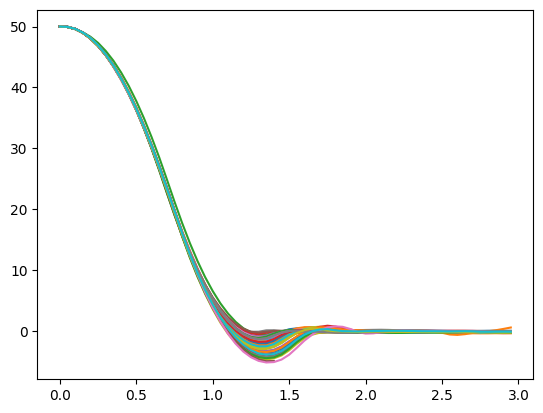

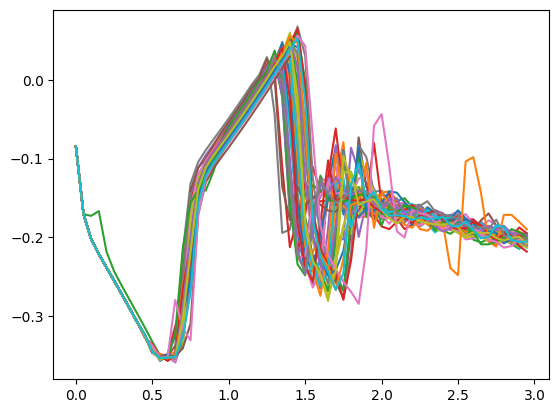

In [10]:
for i in range(len(all_z_m)):
  z_m = all_z_m[i]
  plt.plot(all_time[:len(z_m)],all_z_m[i])
plt.show()
for i in range(len(all_look_angle)):
  look_angle = all_look_angle[i]
  plt.plot(all_time[:len(look_angle)],all_look_angle[i])
plt.show()
